In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Instructions

The python package "hn2016_falwa" contains a function "qgpv_Eqlat_LWA" that computes the finite-amplitude local wave activity (LWA) based on quasi-geostrophic potential vorticity (QGPV) field derived from Reanalysis data with spherical geometry. It differs from the function "barotropic_Eqlat_LWA" that a hemispheric domain (instead of global domain) is used to compute both equivalent-latitude relationship and LWA. This is to avoid spurious large values of LWA near the equator arising from the small meridional gradient of QGPV there.

## Cold Snap in Northeast America and Canada
This sample code computes and plots the maps of local wave activity on Jan 2, 2014, where there is a blast of **Arctic air** into North America. LWA is large over the affected region during the cold snap.

## Contact

Please make inquiries and report issues via Github: https://github.com/csyhuang/hn2016_falwa/issues

In [2]:
%matplotlib inline
import hn2016_falwa # Module for plotting local wave activity (LWA) plots and 
                      # the corresponding equivalent-latitude profile
from math import *
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle

def load_pickle(fname):
    f = open(fname)
    var = pickle.load(f)
    f.close()
    return var

def dump_pickle(variable,fname):
    f = open(fname, 'w')
    pickle.dump(variable, f)
    f.close()
    return None

# --- Parameters --- #
a = 6.378e+6 # Earth's radius

# --- Load the zonal wind and QGPV at 240hPa --- #
u_QGPV_File = Dataset('/data/csyhuang/Jan11_2016_data/Manuscript2_Data/Manuscript2_Final/QGPV_2014.nc', mode='r')
# u_File = Dataset('')

# --- Read in longitude and latitude arrays --- #
xlon = u_QGPV_File.variables['longitude'][:]
ylat = u_QGPV_File.variables['latitude'][:]
clat = np.abs(np.cos(ylat*pi/180.)) # cosine latitude
nlon = xlon.size
nlat = ylat.size

# --- Parameters needed to use the module HN2015_LWA --- #
dphi = (ylat[2]-ylat[1])*pi/180. # Equal spacing between latitude grid points, in radian
area = 2.*pi*a*a*(np.cos(ylat[:,np.newaxis]*pi/180.)*dphi)/float(nlon) * np.ones((nlat,nlon))
area = np.abs(area) # To make sure area element is always positive (given floating point errors). 

# --- Datestamp ---
Start_date = dt.datetime(2014, 1, 2, 0, 0)
delta_t = dt.timedelta(hours=6)
Datestamp = [Start_date + delta_t*tt for tt in range(4)]

# --- Read in the absolute vorticity field from the netCDF file --- #
# u = u_QGPV_File.variables['U'][:]
QGPV = u_QGPV_File.variables['QGPV'][4:8,6,:,:]

u_QGPV_File.close()

# --- Set colorbar range for the 3 variables ---
u_caxis = np.arange(-44,89,11)
LWA_axis = np.linspace(0,313,11,endpoint=True)

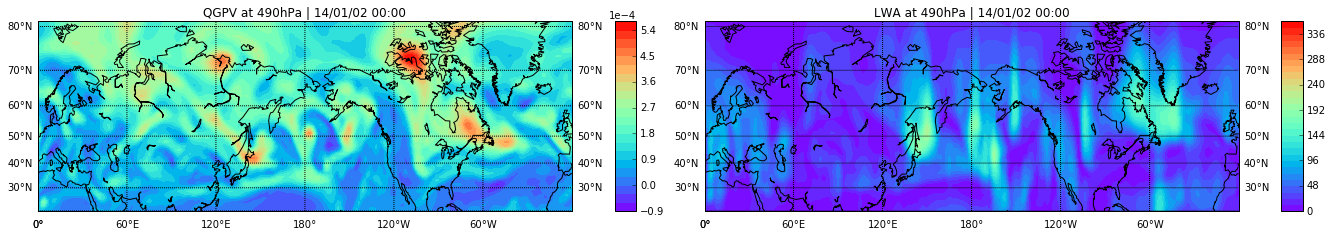

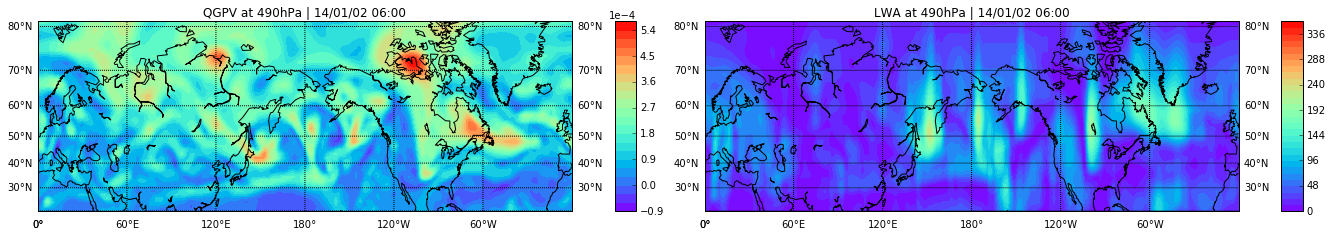

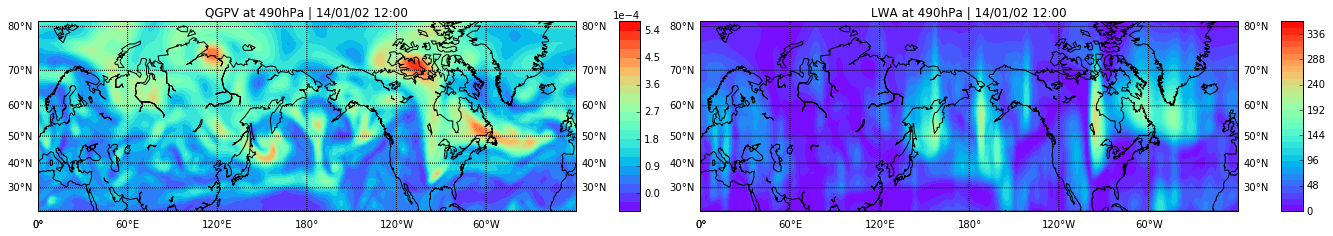

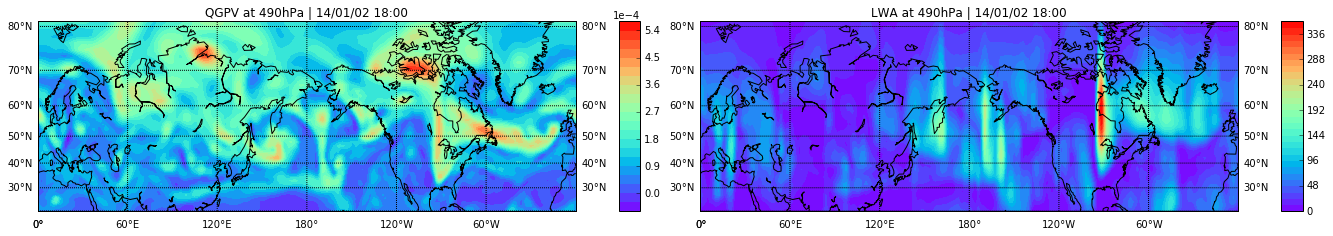

In [3]:
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

# --- Computing local wave activity and plot them ---
for tt in range(4):
    Qref, LWA = hn2016_falwa.qgpv_Eqlat_LWA(ylat,QGPV[tt,:,:],area,a*clat*dphi)
    
    # === Save files for plotly ===
    dump_pickle(LWA,'LWA_'+Datestamp[tt].strftime("%y%m%d_%H%M")+'.pckl')
    dump_pickle(QGPV[tt,:,:],'QGPV_'+Datestamp[tt].strftime("%y%m%d_%H%M")+'.pckl')
    
    fig = plt.figure(figsize=(18,3))

    ax = fig.add_subplot(121)
    ax.set_title('QGPV at 490hPa | '+Datestamp[tt].strftime("%y/%m/%d %H:%M"))
    m = Basemap(llcrnrlon=0,llcrnrlat=20.,urcrnrlon=360,urcrnrlat=81,fix_aspect=False,projection='mill')
    QGPV_plot, lons = addcyclic(QGPV[tt,:,:], xlon)
    lons, lats = np.meshgrid(lons, ylat) # find x,y of map projection grid.
    x, y = m(lons, lats)
    cs = m.contourf(x,y,QGPV_plot,21,cmap='rainbow')
    cb = m.colorbar(cs,"right",size="4%", pad='8%')
    cb.formatter.set_powerlimits((0, 0))
    cb.ax.yaxis.set_offset_position('right')                         
    cb.update_ticks()    
    m.drawcoastlines(linewidth=1.0)
    m.drawparallels(np.arange(-80,81,10),labels=[1,1,0,0])
    m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

    ax = fig.add_subplot(122)
    ax.set_title("LWA at 490hPa | "+Datestamp[tt].strftime("%y/%m/%d %H:%M"))
    m = Basemap(llcrnrlon=0,llcrnrlat=20.,urcrnrlon=360,urcrnrlat=81,fix_aspect=False,projection='mill')
    LWA_plot, lons = addcyclic(LWA, xlon)
    lons, lats = np.meshgrid(lons, ylat) # find x,y of map projection grid.
    x, y = m(lons, lats)
#     cs = m.contourf(x,y,LWA_plot,LWA_axis,cmap='Jet')
    cs = m.contourf(x,y,LWA_plot,np.arange(0,361,12),cmap='rainbow')
    cb = m.colorbar(cs,"right",size="4%", pad='8%')
    cb.formatter.set_powerlimits((0, 0))
    m.drawcoastlines(linewidth=1.0)
    m.drawparallels(np.arange(-80,81,10),labels=[1,1,0,0])
    m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

    plt.tight_layout(pad=0.4, w_pad=4.0, h_pad=2.0)
